# Navigation(Training)

---

In this notebook, the Unity ML-Agents is trained to collect bananas in the environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import gym
get_ipython().system('pip install box2d')
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

plt.ion()


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe",no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)

BananaBrain


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Training an Agent

This code is training the RL agent. When all AlhpaRun, BetaRun, ... flags are set to false line 107 is run to train an agent for a single set of hyperparameters. The number of episodes to run is specified in line 12 as n_episodes.
To test over a grid of one hyperparameter, the grid can be set in alpha_range, etc. setting AlphaRun to True. The current configuration of hyperparameters supplied the fastest learning on average over multiple runs.

#### Further options
DoProfile: Profiling for a single run can be enabled when doing a single run setting DoProfile to True<br>
DoPER: Prioritized experience replay(PER) can be enabled setting DoPER to True, though I could not discover stable performance gains in learning. It is likely that use of PER is not helpful for this environment, coompared to simple experience replay.

In [5]:
DoProfile = False
DoPrintMem = False
DoPER = False

if not DoPER:from dqn_agent import Agent
else:from dqn_agent_per import AgentPER
    
import time
import cProfile


def dqn(alpha,beta,gamma,tau,LR,batch_size,buffer_size,n_episodes=900, max_t=800, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    if not DoPER:agent = Agent(alpha,beta,gamma,tau,LR,batch_size,state_size=state_size, action_size=action_size, seed=0, buffer_size = buffer_size)
    else:agent = AgentPER(alpha,beta,gamma,tau,LR,batch_size,state_size=state_size, action_size=action_size, seed=0, buffer_size = buffer_size)
        
    print('Active Device : ',agent.device)

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        # print('   ------   Memory Length = ',len(agent.memory))
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        
        tic = time.perf_counter()
        for t in range(max_t):
            action = agent.act(state, eps)
            # print('------------------------------------------')
            # print('Take action : {} (step {} in epsiode: {}) -- PER : {} '.format(action,t,i_episode,len(agent.memory))) #,action,' in t = ',t, ,i_episode,') brain is : ',brain_name, ' type(action)', type(action))
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
                
        if DoPrintMem:agent.mem_print_summary()
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        toc = time.perf_counter()
        # print('------------------------------------------')
        # print('------------------------------------------')
        # print('Episode {}\tAverage Score: {:.2f} || NumSteps : {} || Memory : {} || Ep_Time : {:7.5f}'.format(i_episode, np.mean(scores_window),t,len(agent.memory),toc-tic))
        # agent.memory.mem_print_summary()
        # print('Episode took {} seconds'.format(toc-tic))
        print('\rEpisode {}\tAverage Score: {:.2f} || NumSteps : {} || Memory : {} || Ep_Time : {:7.5f}'.format(i_episode, np.mean(scores_window),t,len(agent.memory),toc-tic), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} || NumSteps : {} || Memory : {} || Ep_Time : {:7.5f}'.format(i_episode, np.mean(scores_window),t,len(agent.memory),toc-tic))
        # for t
    # for episode
            
    print('DQN done.')
            
    return scores,agent

alpha = 0.5
beta = 0.6
gamma = 0.98
tau = 0.001
LR = 0.0005
batch_size = 64
buffer_size = 100000
inside = 1   # Number of runs in the inside loop for hparam exploration

alpha_range = [0.3,0.5,0.7,0.8,0.9]
beta_range = [0.3,0.5,0.7,0.8,0.9]
gamma_range = [0.98] #[0.95,0.96,0.97,0.98,0.99]
tau_range = [0.0003,0.0006,0.001,0.002,0.003,0.005]
LR_range = [0.0001,0.0003,0.0005,0.0008,0.001]
batch_range = [16,32,64,96,128]
buffer_range = [br*10000 for br in [1,2,3,5,7,10,15,20]]

AlphaRun = False
BetaRun = False
GammaRun = False
TauRun = False
LRRun = False
BatchRun = False
BufferRun = False
AnyRun = AlphaRun or GammaRun or TauRun or LRRun or BatchRun or BufferRun

# Single Run
if not AnyRun:
    if DoProfile: 
        cProfile.run('scores, agent = dqn(alpha,beta,gamma,tau,LR,batch_size,buffer_size)','ProfStats')
    else:
        scores, agent = dqn(alpha,beta,gamma,tau,LR,batch_size,buffer_size)

# Running over different parameters as indicated by xRun flags
if AlphaRun:
    olda = alpha
    for g in alpha_range:
        alpha = g
        for g2 in np.arange(inside):
            print('Alpha : ',alpha)
            scores,agent = dqn(alpha,beta,gamma,tau,LR,batch_size,buffer_size)
        alpha = olda

if BetaRun:
    oldb = beta
    for g in beta_range:
        beta = g
        for g2 in np.arange(inside):
            print('Beta : ',beta)
            scores,agent = dqn(alpha,beta,gamma,tau,LR,batch_size,buffer_size)
        alpha = olda

if GammaRun:
    oldg = gamma
    for g in gamma_range:
        gamma = g
        for g2 in np.arange(inside):
            print('Gamma : ',gamma)
            scores = dqn(alpha,beta,gamma,tau,LR,batch_size,buffer_size)
        gamma = oldg

if TauRun:
    oldt = tau
    for g in tau_range:
        tau = g
        for g2 in np.arange(inside):
            print('tau : ',tau)
            scores = dqn(gamma,tau,LR,batch_size,buffer_size)
    tau = oldt

if LRRun:
    oldl = LR
    for g in LR_range:
        LR = g
        for g2 in np.arange(inside):
            print('LR : ',LR)
            scores = dqn(gamma,tau,LR,batch_size,buffer_size)
    LR = oldl

if BatchRun:
    oldbs = batch_size
    for g in batch_range:
        batch_size = g
        for g2 in np.arange(inside):
            print('batch_size : ',batch_size)
            scores = dqn(gamma,tau,LR,batch_size,buffer_size)
    batch_size = oldbs

if BufferRun:
    oldbs = buffer_size
    for g in buffer_range:
        buffer_size = g
        for g2 in np.arange(inside):
            print('buffer_size : ',buffer_size)
            scores = dqn(gamma,tau,LR,batch_size,buffer_size)
    buffer_size = oldbs


Active Device :  cpu
Episode 100	Average Score: 0.78 || NumSteps : 299 || Memory : 30000 || Ep_Time : 0.84291
Episode 200	Average Score: 4.48 || NumSteps : 299 || Memory : 60000 || Ep_Time : 0.91120
Episode 300	Average Score: 8.30 || NumSteps : 299 || Memory : 90000 || Ep_Time : 0.93574
Episode 400	Average Score: 9.47 || NumSteps : 299 || Memory : 100000 || Ep_Time : 0.86664
Episode 500	Average Score: 11.95 || NumSteps : 299 || Memory : 100000 || Ep_Time : 0.83295
Episode 600	Average Score: 13.57 || NumSteps : 299 || Memory : 100000 || Ep_Time : 0.85699
Episode 700	Average Score: 14.36 || NumSteps : 299 || Memory : 100000 || Ep_Time : 0.92746
Episode 800	Average Score: 15.05 || NumSteps : 299 || Memory : 100000 || Ep_Time : 0.80660
Episode 900	Average Score: 15.63 || NumSteps : 299 || Memory : 100000 || Ep_Time : 0.92614
DQN done.


When finished, you can close the environment. Plot scores over learning time and plot statistics for deltaQs for PER

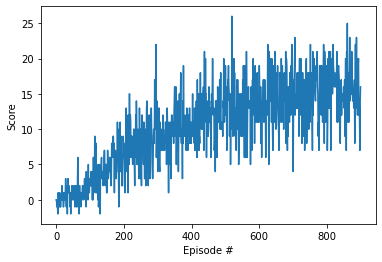

In [12]:
# env.close()

# torch.save(agent.qnetwork_local.state_dict(), 'trained_banana_hunter.pth')

if DoPrintMem:AllQ, AllP = agent.mem_print_summary()
# print(len(AllQ))
# print(len(AllP))
# AllQ, AllP = agent.memory.mem_print_summary()
# print('Standard-Deviation of deltaQs',np.std(AllQ))

# plot the scores
if True:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.savefig('BananaScores.pdf')  
    plt.show()
    
if DoPER:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.hist(AllQ, bins = 200)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

